In [25]:
import csv
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import style
from collections import namedtuple

In [26]:
n_agents = 2
history = 1
n_steps = 9999
buffer_rate = 2


rewards = []
actions = []
states = []

with open('data.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        row = [float(r) for r in row]
        rewards.append(row[:n_agents])
        actions.append(row[n_agents: 2*n_agents])
        states.append(row[2*n_agents:])

rewards = np.array(rewards)
actions = np.array(actions)
states = np.array(states)       

In [27]:
print(rewards.shape)
print(actions.shape)
print(states.shape)

(10000, 2)
(10000, 2)
(10000, 8)


### Get features in a scenario with history
We want to just get the features from the last time step. 

In [28]:
# state = namedtuple('state', ["sinr", "interference_caused", "n_success", "tx_powers",
#                              "interference_sensed", "buffer"])
n_features_per_agent = len(states[1]) // n_agents

did_transmit = []
n_success = []
interference_sensed = []
buffer = []

for s in states:
    #step_sinr = []
    step_n_success = []
    step_did_transmit = []
    step_interference_sensed = []
    step_buffer = []
    for i in range(n_agents):
        agent_features = s[i * n_features_per_agent: (i+1) * n_features_per_agent]
        
        step_did_transmit.append(agent_features[0])
        step_n_success.append(agent_features[1])
        step_interference_sensed.append(agent_features[2])
        step_buffer.append(agent_features[3])

    did_transmit.append(step_did_transmit)
    n_success.append(step_n_success)
    interference_sensed.append(step_interference_sensed)
    buffer.append(step_buffer)

    
did_transmit = np.array(did_transmit)
n_success = np.array(n_success)
interference_sensed = np.array(interference_sensed)
buffer = np.array(buffer)

In [29]:
print(actions)

[[-1. -1.]
 [ 1.  2.]
 [ 0.  2.]
 ...
 [ 2.  1.]
 [ 2.  2.]
 [ 2.  2.]]


In [30]:
print(sum(n_success[:, 0]))
print(np.sum(n_success, axis=0))
print(np.sum(rewards, axis=1))
unique, counts = np.unique(np.sum(rewards, axis=1), return_counts=True)
dict(zip(unique, counts))


4417.0
[4417. 4448.]
[0. 1. 1. ... 1. 1. 1.]


{-2.0: 651, 0.0: 483, 1.0: 8866}

In [31]:
print(actions.flatten())
unique, counts = np.unique(actions.flatten(), return_counts=True)
dict(zip(unique, counts))

[-1. -1.  1. ...  2.  2.  2.]


{-1.0: 2, 0.0: 1297, 1.0: 1636, 2.0: 17065}

### Convert to averages over a time window

In [32]:
did_transmit.shape

(10000, 2)

In [33]:
history = 100

avgs = [[] for _ in range(n_agents)] # rewards

# Features
avg_did_transmit = [[] for _ in range(n_agents)]
avg_interference_sensed = [[] for _ in range(n_agents)] 
avg_buffer = np.zeros((states.shape[0], n_agents))

avg_throughput = np.zeros((states.shape[0], n_agents))

for i in range(history, len(rewards)):
    for j in range(n_agents):
        avgs[j].append(np.mean(rewards[:, j][i - history: i]))
        avg_did_transmit[j].append(np.mean(did_transmit[:, j][i - history: i]))
        avg_interference_sensed[j].append(np.mean(did_transmit[:, j][i - history: i]))

        avg_buffer[i][j] = np.mean(buffer[:, j][i - history: i])
        avg_throughput[i][j] = np.mean(n_success[:, j][i - history: i])


reward_sum = [sum(rewards[i]) for i in range(len(rewards))]
avg_reward_sum = []
for i in range(history, len(rewards)):
    avg_reward_sum.append(np.mean(reward_sum[i - history: i]))

# Reward

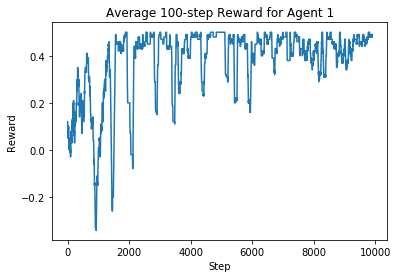

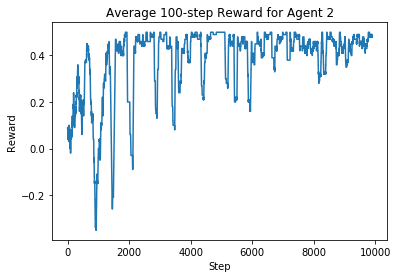

In [34]:
for i in range(n_agents):
    fig = plt.figure()
    plt.plot(avgs[i])
    plt.title("Average 100-step Reward for Agent " + str(i + 1))
    plt.xlabel("Step")
    plt.ylabel("Reward")
    
    #plt.show()
    #plt.savefig("reward" + str(i+1) + ".png")

# Actions

In [35]:
# Using np.unique is another way of doing this

agent_action_probs = [] # Time slice, agent_idx, action
possible_actions = sorted(list(set(actions.flatten())))
print("possible_actions", possible_actions)
steps = 100

for i in range(len(actions)//steps):
    action_slice = actions[i*steps: (i+1)*steps]
    agent_action_probs_this_time_slice = []
    for agent_index in range(n_agents):
        agent_actions = [0] * len(possible_actions)
        agent_action_slice = action_slice[:, agent_index]
        
        for i, action in enumerate(possible_actions):
            agent_actions[i] = np.count_nonzero(agent_action_slice == action)
             
        agent_action_probs_this_time_slice.append(np.array(agent_actions) / steps)
    
    agent_action_probs.append(agent_action_probs_this_time_slice)        

agent_action_probs = np.array(agent_action_probs)

possible_actions [-1.0, 0.0, 1.0, 2.0]


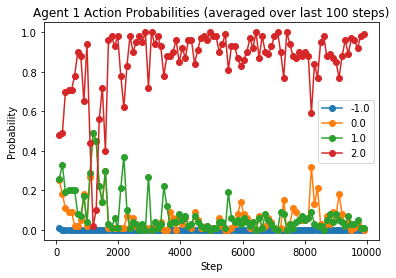

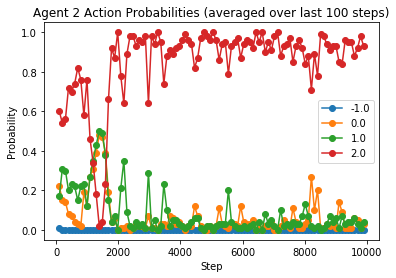

In [36]:
step_list = list(range(100, len(actions), 99))
labels = [str(a) for a in possible_actions]
#plt.plot(step_list, agent_action_probs[:, 0], label=['-1', '0', '1'])

for i in range(n_agents):
    fig = plt.figure()

    for j in range(len(possible_actions)):
        plt.plot(step_list, agent_action_probs[:, i, j], label=labels[j], marker='o')
    
    plt.legend(loc="right")
    plt.title("Agent " + str(i + 1) + " Action Probabilities (averaged over last 100 steps)")
    plt.xlabel("Step")
    plt.ylabel("Probability")
    #plt.savefig("Agent " + str(i + 1) + " Action Probabilities.png")

# Features
- did_transmit
- n_success 
- interference_sensed 
- buffer

## Did transmit

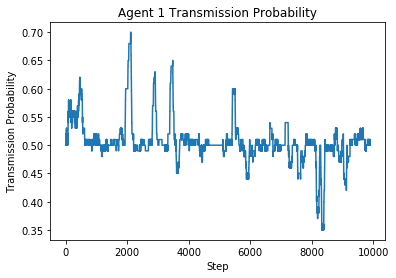

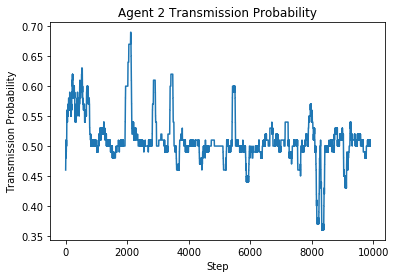

In [37]:
for i in range(n_agents):
    fig = plt.figure()
    plt.plot(avg_did_transmit[i])
    
    plt.title("Agent " + str(i + 1) + " Transmission Probability")
    plt.xlabel("Step")
    plt.ylabel("Transmission Probability")
    #plt.savefig("Agent " + str(i + 1) + " Buffer.png")

## Transmission Successful
Same as throughput

## Interference-sensed

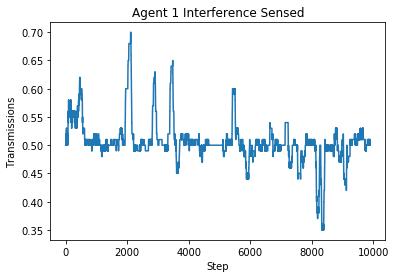

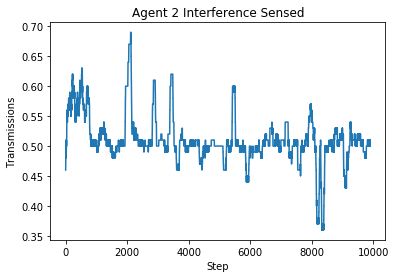

In [38]:
for i in range(n_agents):
    fig = plt.figure()
    plt.plot(avg_interference_sensed[i])
    
    plt.title("Agent " + str(i + 1) + " Interference Sensed")
    plt.xlabel("Step")
    plt.ylabel("Transmissions")
    #plt.savefig("Agent " + str(i + 1) + " Buffer.png")

## Buffer

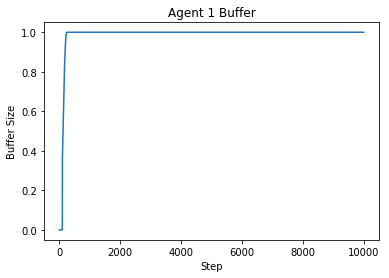

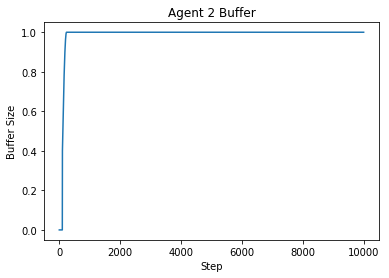

In [39]:
for i in range(n_agents):
    fig = plt.figure()
    plt.plot(avg_buffer[:, i])
    
    plt.title("Agent " + str(i + 1) + " Buffer")
    plt.xlabel("Step")
    plt.ylabel("Buffer Size")
    #plt.savefig("Agent " + str(i + 1) + " Buffer.png")

### Agent Throughput 

In packets per step, averaged for a 100 step window

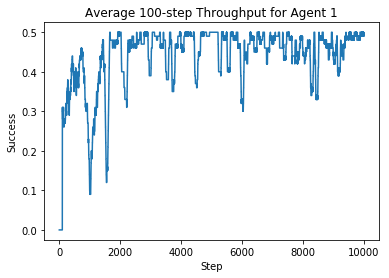

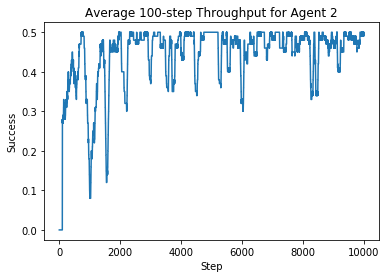

In [40]:
for i in range(n_agents):
    fig = plt.figure()
    plt.plot(avg_throughput[:, i])
    plt.title("Average 100-step Throughput for Agent " + str(i + 1))
    plt.xlabel("Step")
    plt.ylabel("Success")
    
    #plt.show()
    #plt.savefig("Success" + str(i+1) + ".png")

### Network throughput
Sum the throughput for all agents.

For the same history window as used in the throughput.

Text(0,0.5,'Avg Throughput (packet/step)')

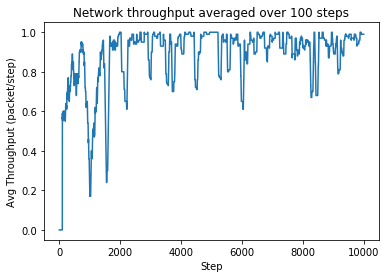

In [41]:
network_throuput = np.sum(avg_throughput, axis=1)

fig = plt.figure()
plt.plot(network_throuput)
plt.title("Network throughput averaged over 100 steps")
plt.xlabel("Step")
plt.ylabel("Avg Throughput (packet/step)")

### Fairness
Jain's fairness index

In [42]:
fairness = []

for step_idx in range(n_steps - history):
    numerator = sum(avg_throughput[step_idx, :])**2
    denominator = n_agents * sum(np.square(avg_throughput[step_idx, :]))
    fairness.append(numerator / denominator)

/home/farquhar13/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


Text(0,0.5,'Fairness')

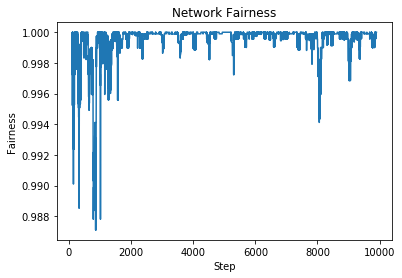

In [43]:
plt.plot(fairness)
plt.title("Network Fairness")
plt.xlabel("Step")
plt.ylabel("Fairness")
#plt.savefig("Fariness.png")